In [1]:
import os
import pickle
from kid_readout.utils import readoutnc
from kid_readout.analysis import noise_measurement
plt.rcParams['font.size'] = 11

updated file list


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def histogram(ax, bins, values, **kwargs):
    x = np.zeros(2 * bins.size)
    y = np.zeros(x.size)
    x[0::2] = x[1::2] = bins
    y[1:-2:2] = y[2:-1:2] = values
    ax.plot(x, y, **kwargs)
    return x, y


def log_bin(df, data, n_bins):
    """
    Bin positive-frequency data spaced by frequency df into n_bins bins.
    
    The data points are assumed to correspond to frequencies [df, 2 df, 3 df, ..., data.size * df]
    """
    # The first bin edge is at df * (-1 / 2 + 0 + 1) = df / 2
    # The last bin edge is at df * (-1/2 + n_bins + data.size - n_bins + 1) = df * (data.size + 1 / 2)
    bin_edges = df * (-1 / 2 + np.arange(n_bins + 1) + 
                      np.logspace(0, np.log10(data.size - n_bins + 1), n_bins+1))
    f = df * np.arange(1, data.size + 1)
    # Values inside the given extreme bin edges are in [1, x.size]
    bin_indices = np.digitize(f, bin_edges) - 1
    binned_data = np.zeros(n_bins)
    counts = np.zeros(n_bins, dtype=np.int)
    for bin_index in range(n_bins):
        indices = bin_indices == bin_index
        binned_data[bin_index] = np.mean(data[indices])
        counts[bin_index] = np.sum(indices)
    return bin_edges, binned_data, counts

In [3]:
data_directory = '/data/readout'
resonator_index = 13  # This should be the 164 MHz resonance, aka channel 8

In [26]:
cw_ncs = ['2015-05-19_101902_mmw_continuous-wave_148_GHz.nc',  # 9.0
          '2015-05-19_105620_mmw_continuous-wave_148_GHz.nc',  # 8.5
          '2015-05-19_112410_mmw_continuous-wave_148_GHz.nc',  # 8.0
          '2015-05-19_115733_mmw_continuous-wave_148_GHz.nc',  # 7.5
          '2015-05-19_125442_mmw_continuous-wave_148_GHz.nc',  # 7.0
          '2015-05-19_132234_mmw_continuous-wave_148_GHz.nc',  # 6.5
          '2015-05-19_161340_mmw_continuous-wave_148_GHz.nc',  # 6.0
          '2015-05-19_171426_mmw_continuous-wave_148_GHz.nc',  # 5.5
          '2015-05-19_191152_mmw_continuous-wave_148_GHz.nc',  # 5.0
          '2015-05-19_231919_mmw_continuous-wave_148_GHz.nc',  # 4.5
          '2015-05-20_090542_mmw_continuous-wave_148_GHz.nc',  # 4.0
          '2015-05-20_100424_mmw_continuous-wave_148_GHz.nc',  # 3.5
          '2015-05-20_105213_mmw_continuous-wave_148_GHz.nc',  # 3.0
          ]

bb_ncs = ['2015-05-12_113832_mmw_noise_broadband.nc',  # 9.0
          '2015-05-12_120435_mmw_noise_broadband.nc',  # 8.5
          '2015-05-12_123322_mmw_noise_broadband.nc',  # 8.0
          '2015-05-12_133122_mmw_noise_broadband.nc',  # 7.5
          '2015-05-12_140235_mmw_noise_broadband.nc',  # 7.0
          '2015-05-12_192735_mmw_noise_broadband.nc',  # 6.5
          '2015-05-12_195908_mmw_noise_broadband.nc',  # 6.0
          '2015-05-12_203101_mmw_noise_broadband.nc',  # 5.5
          '2015-05-13_102207_mmw_noise_broadband.nc',  # 5.0
          '2015-05-13_113833_mmw_noise_broadband.nc',  # 4.5
          '2015-05-13_123152_mmw_noise_broadband.nc',  # 4.0
          '2015-05-13_151154_mmw_noise_broadband.nc',  # 3.5
          '2015-05-13_154402_mmw_noise_broadband.nc',  # 3.0
          ]

In [5]:
save_directory = '../Max/2015-12-15_unbinned'

# Orient

In [6]:
cw_nc_a29_tt7 = readoutnc.ReadoutNetCDF(os.path.join(data_directory, cw_ncs[11]))

In [7]:
len(cw_nc_a29_tt7.sweeps)

10

In [8]:
len(cw_nc_a29_tt7.timestreams)

10

The sweep/stream pairs consist of  
0 41 coarse off / short modulated on coarse  
1 41 fine off / long modulated off  
2 41 coarse on / short modulated on coarse   
3 41 fine on / long on  
4 38 fine on / long on  
5 35 fine on / long on  
6 32 fine on / long on  
7 29 fine on / long on  
8 26 fine on / long on  
9 23 fine on / long on

In [9]:
# The sweep/timestream index for attenuation 29.
index_a29 = 7

I think there are several measurements of the hardware state per timestream, one per log_hw_state() call.

In [10]:
cw_nc_a29_tt7.dac_atten

array([ 41.,  41.,  41.,  41.,  41.,  41.,  41.,  41.,  38.,  38.,  35.,
        35.,  32.,  32.,  29.,  29.,  26.,  26.,  23.,  23.], dtype=float32)

In [11]:
cw_nc_a29_tt7.close()

# Calculate PSD chunk size for 32 degrees of freedom

This length is calculated below.

In [12]:
pca_NFFT = 2**15

This is the highest optical power data that passes cuts:

In [13]:
cw_snm_a29_tt07 = noise_measurement.SweepNoiseMeasurement(cw_ncs[11],
                                                          sweep_group_index=index_a29,
                                                          timestream_group_index=index_a29,
                                                          resonator_index=resonator_index,
                                                          pca_NFFT=pca_NFFT,
                                                          pca_detrend=mlab.detrend_none,
                                                          pca_use_log_bins=False
                                                         )

/home/flanigan/kid_readout/kid_readout/analysis/iqnoise.py:183: ComplexWarning: Casting complex values to real discards the imaginary part
  Pxx[:, i] = np.conjugate(fx[:numFreqs]) * fx[:numFreqs]
/home/flanigan/kid_readout/kid_readout/analysis/iqnoise.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  Pyy[:, i] = np.conjugate(fy[:numFreqs]) * fy[:numFreqs]
/home/flanigan/kid_readout/kid_readout/analysis/iqnoise.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  S[0, k] = ss[0, 0]
/home/flanigan/kid_readout/kid_readout/analysis/iqnoise.py:93: ComplexWarning: Casting complex values to real discards the imaginary part
  S[1, k] = ss[1, 1]


In [14]:
cw_snm_a29_tt07.atten

29.0

The length of the data stream in seconds is

In [15]:
cw_snm_a29_tt07.fractional_fluctuation_timeseries.size / cw_snm_a29_tt07.timeseries_sample_rate

33.554431999999998

In [16]:
cw_snm_a29_tt07.fractional_fluctuation_timeseries.dtype

dtype('complex64')

The "fractional fluctuation" timeseries contains both phase and amplitude data. Each of these has length

In [17]:
np.log2(cw_snm_a29_tt07.fractional_fluctuation_timeseries.size)

19.0

To calculate the PSD, they are split into chunks each containing NFFT complex samples:

In [18]:
np.log2(pca_NFFT)

15.0

Negative frequency bins contain the conjugates of the values in the corresponding positive frequency bins. Taking the norm of the value in each bin produces a chi-squared distribution with two degrees of freedom. Transforming the double-sided spectra into single-sided spectra simply multiplies the real value in each positive frequency bin by two, with no effect on the number of degrees of freedom.

The single-sided spectra have length $2^{15 - 1}$ and the value in each bin is chi-square distributed with two degrees of freedom. To obtain 32 degrees of freedom, we average $16 = 2^{19 - 15}$ spectra.

In [19]:
cw_snm_a29_tt07.fractional_fluctuation_timeseries.size / cw_snm_a29_tt07.pca_freq[1:].size

32.0

This is the lowest-power data:

In [20]:
cw_snm_a29_tt17 = noise_measurement.SweepNoiseMeasurement(cw_ncs[1],
                                                          sweep_group_index=index_a29,
                                                          timestream_group_index=index_a29,
                                                          resonator_index=resonator_index,
                                                          pca_NFFT=pca_NFFT,
                                                          pca_detrend=mlab.detrend_none,
                                                          pca_use_log_bins=False
                                                         )

Create log-binned data:

In [21]:
n_bins = 100

In [22]:
bins07, Sx07, Cx07 = log_bin(cw_snm_a29_tt07.pca_freq[1] - cw_snm_a29_tt07.pca_freq[0],
                                 cw_snm_a29_tt07.pca_eigvals[1][1:],
                                 n_bins)
bins07, Si07, Ci07 = log_bin(cw_snm_a29_tt07.pca_freq[1] - cw_snm_a29_tt07.pca_freq[0],
                                 cw_snm_a29_tt07.pca_eigvals[0][1:],
                                 n_bins)
bc07 = bins07[:-1] + np.diff(bins07) / 2

In [23]:
bins17, Sx17, Cx17 = log_bin(cw_snm_a29_tt17.pca_freq[1] - cw_snm_a29_tt17.pca_freq[0],
                                 cw_snm_a29_tt17.pca_eigvals[1][1:],
                                 n_bins)
bins17, Si17, Ci17 = log_bin(cw_snm_a29_tt17.pca_freq[1] - cw_snm_a29_tt17.pca_freq[0],
                                 cw_snm_a29_tt17.pca_eigvals[0][1:],
                                 n_bins)
bc17 = bins17[:-1] + np.diff(bins17) / 2

In [24]:
cw_snm_a29_tt07.pca_freq[1] - cw_snm_a29_tt07.pca_freq[0]

0.476837158203125

Does pca_freq contain the center of the bins? Work out the edge/center issues.

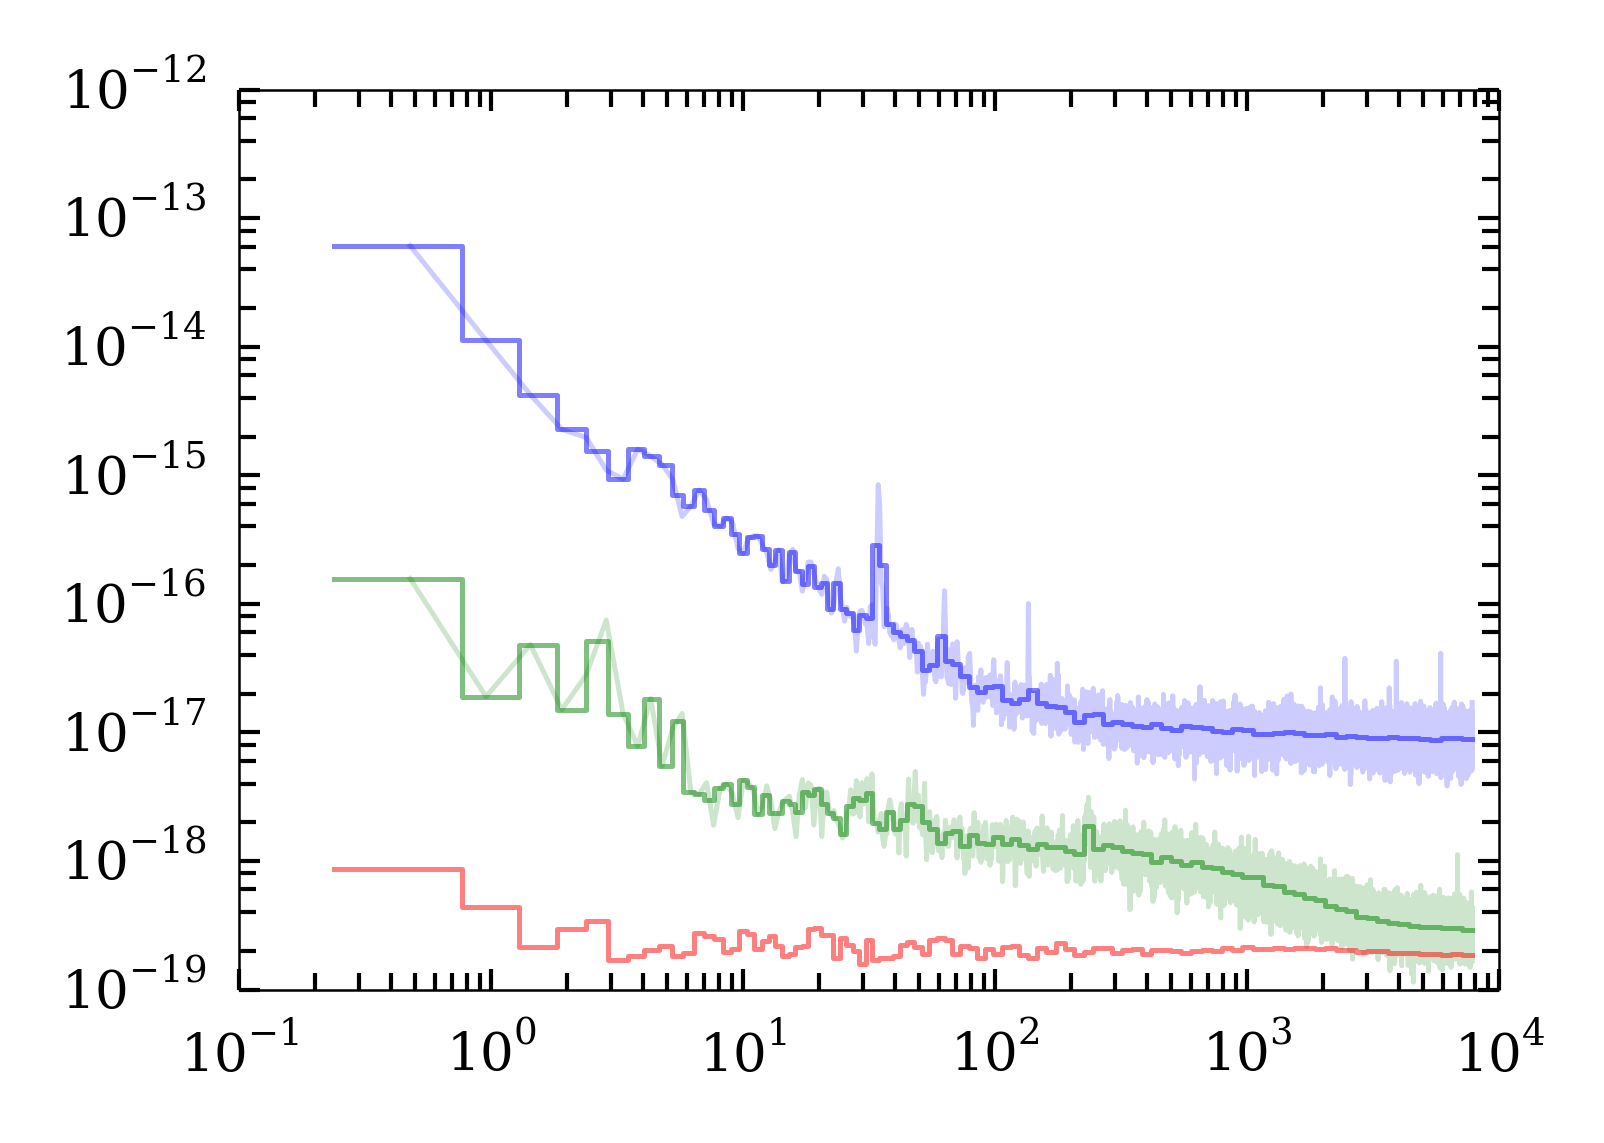

In [25]:
fig, ax = plt.subplots()

ax.loglog(cw_snm_a29_tt17.pca_freq[1:], cw_snm_a29_tt17.pca_eigvals[1][1:], '-g', alpha=0.2)
#ax.loglog(bc17, Sx17, '-', color='green', alpha=1)
histogram(ax, bins17, Sx17, color='green', alpha=0.5)
histogram(ax, bins17, Si17, color='red', alpha=0.5)


ax.loglog(cw_snm_a29_tt07.pca_freq, cw_snm_a29_tt07.pca_eigvals[1], '-b', alpha=0.2)
#ax.loglog(bc07, Sx07, '-', color='blue', alpha=0.5)
histogram(ax, bins07, Sx07, color='blue', alpha=0.5);

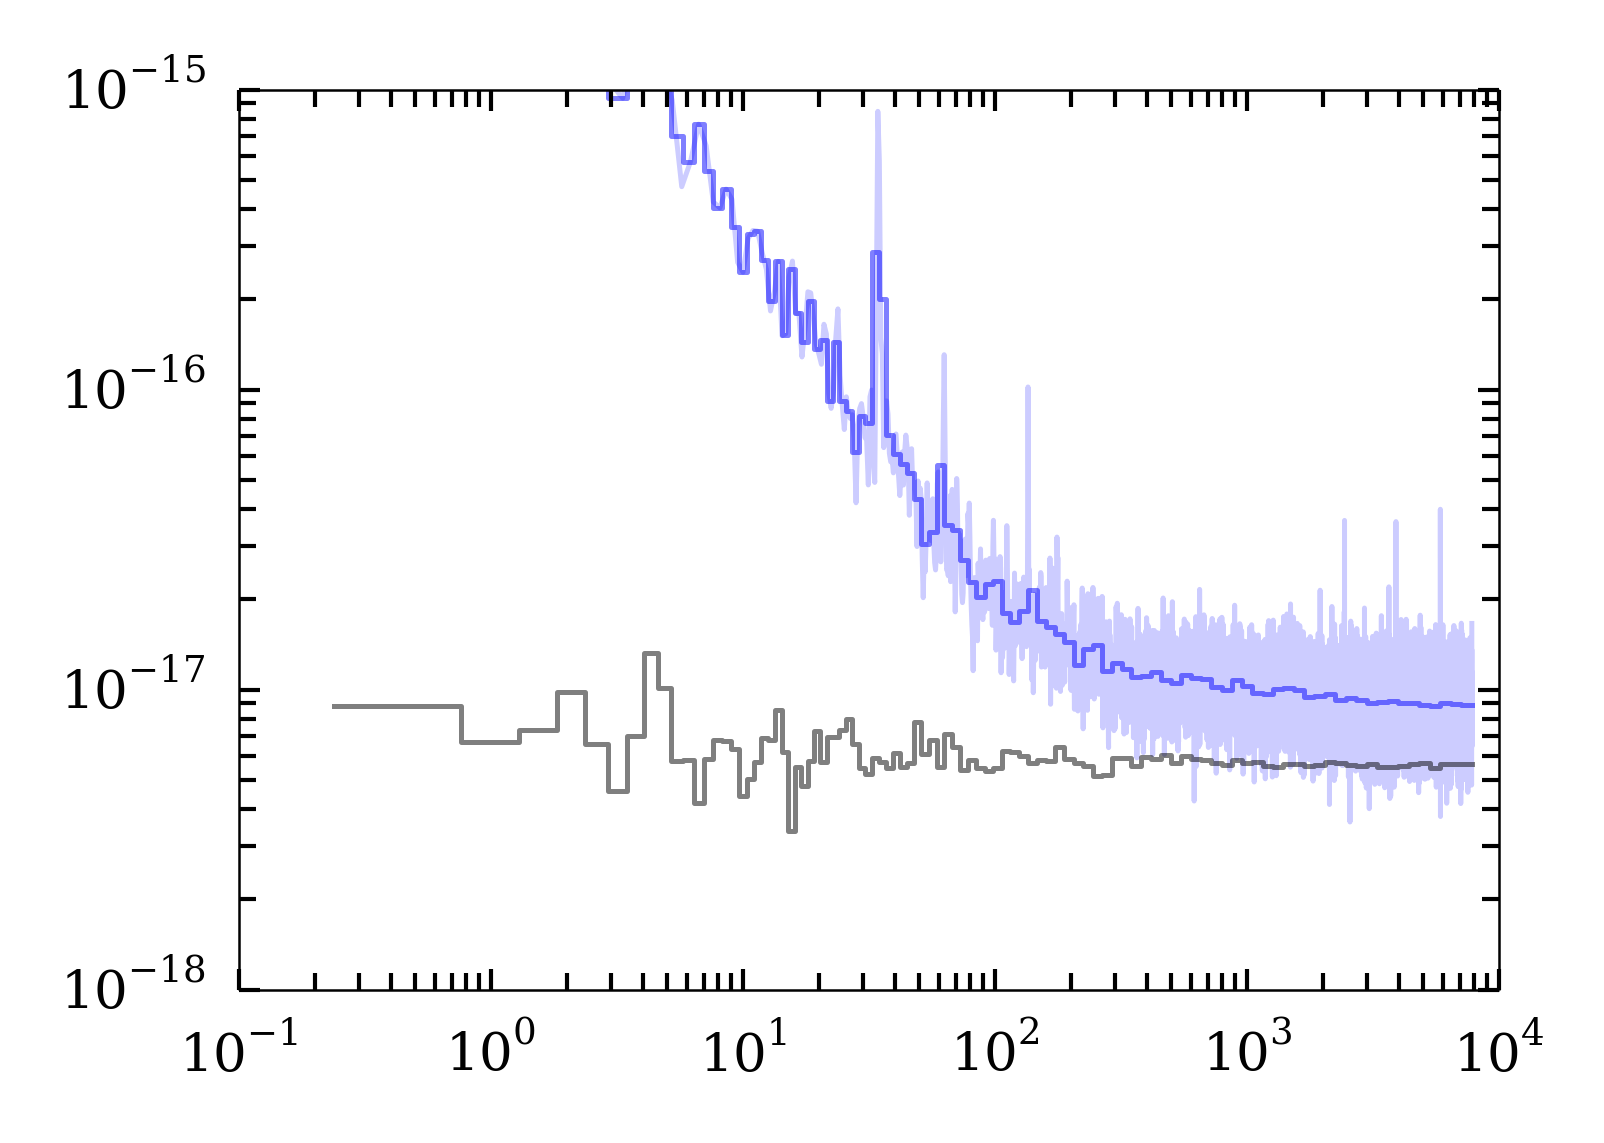

In [191]:
fig, ax = plt.subplots()

ax.plot(cw_snm_a29_tt07.pca_freq,
        cw_snm_a29_tt07.pca_eigvals[1],
        '-b', alpha=0.2)
histogram(ax, bins07, Sx07, color='blue', alpha=0.5)
histogram(ax, bins07, Si07, color='black', alpha=0.5)
#histogram(ax, bins07, Sx07 - cw_snm_a29_tt07.pca_eigvals[0][-1000:].mean(), color='blue', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-18, 1e-15);

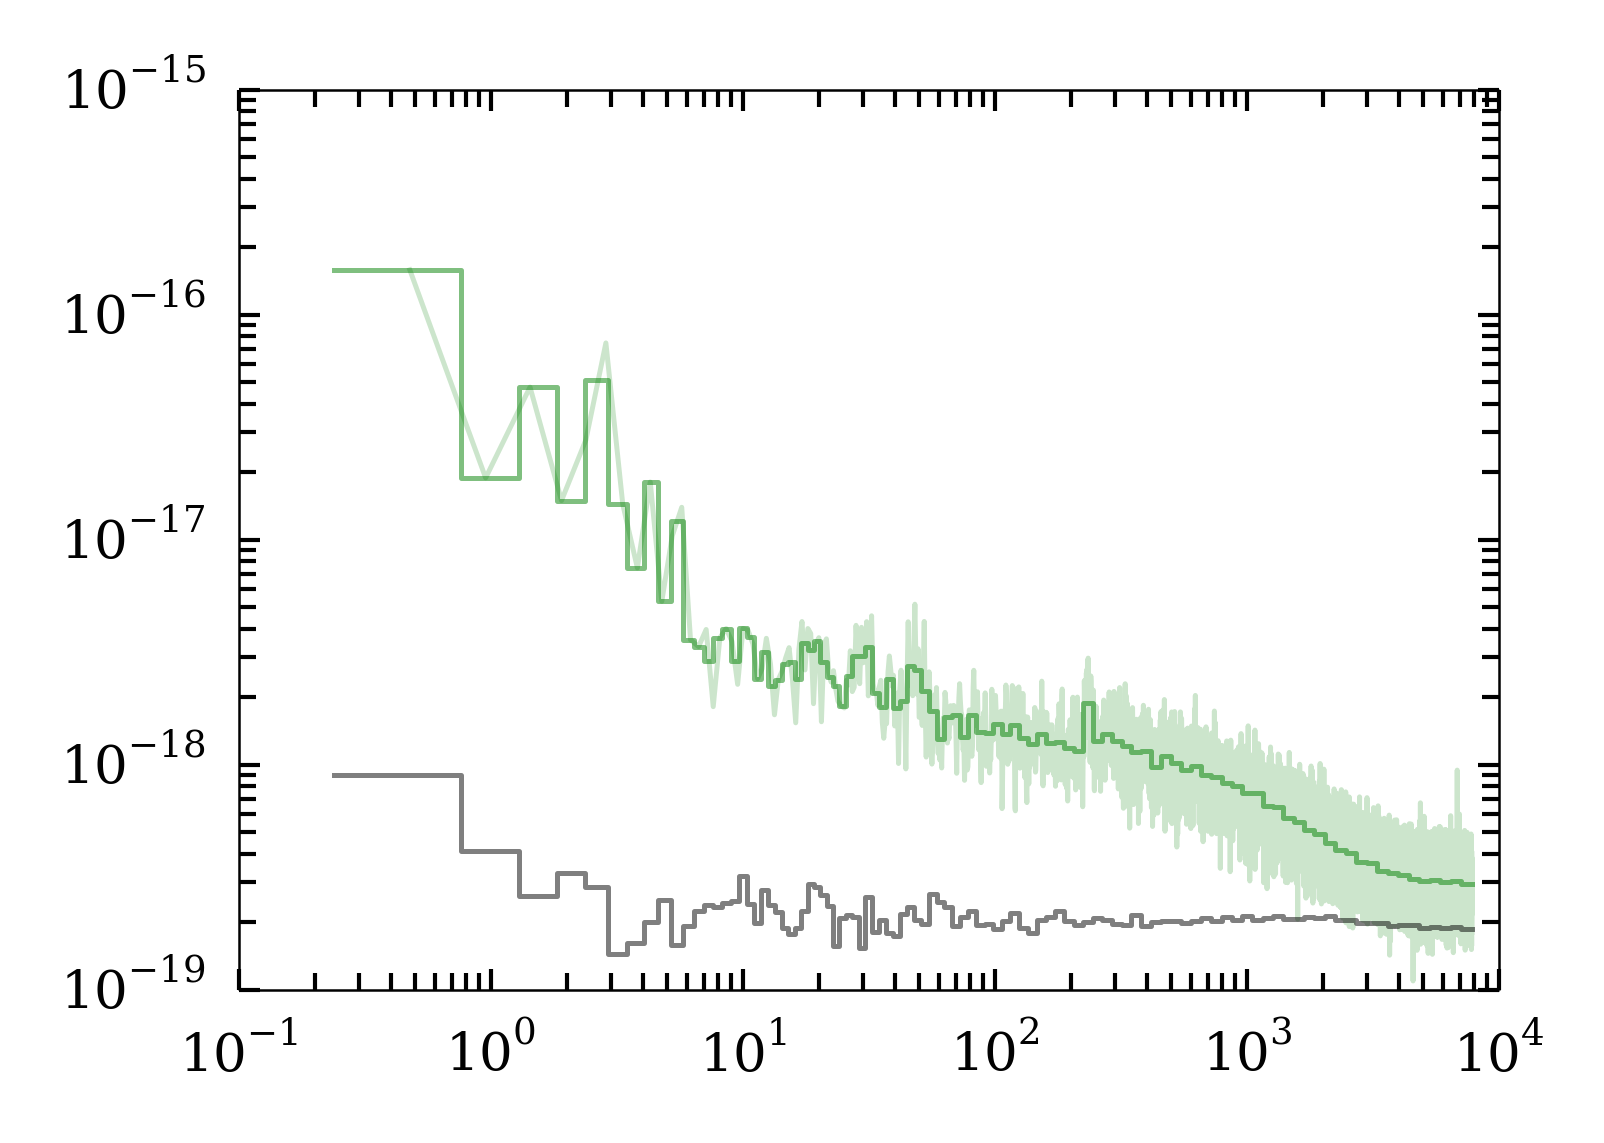

In [193]:
fig, ax = plt.subplots()

ax.plot(cw_snm_a29_tt17.pca_freq,
        cw_snm_a29_tt17.pca_eigvals[1],
        '-g', alpha=0.2)
histogram(ax, bins17, Sx17, color='green', alpha=0.5)
histogram(ax, bins17, Si17, color='black', alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-19, 1e-15);

In [194]:
cw_snm_a29_tt07._close_files()
del(cw_snm_a29_tt07)
cw_snm_a29_tt17._close_files()
del(cw_snm_a29_tt17)

# Despiking broadband data

In [26]:
bb_snm_a29_tt06 = noise_measurement.SweepNoiseMeasurement(bb_ncs[-1],
                                                          sweep_group_index=index_a29,
                                                          timestream_group_index=index_a29,
                                                          resonator_index=resonator_index,
                                                          pca_NFFT=pca_NFFT,
                                                          pca_detrend=mlab.detrend_none,
                                                          pca_use_log_bins=False
                                                         )

In [27]:
n_masked = 15
f_mask = 100
highest = ((bb_snm_a29_tt06.pca_freq <= f_mask).sum() +
            bb_snm_a29_tt06.pca_eigvals[1][bb_snm_a29_tt06.pca_freq > f_mask].argsort())[-n_masked:]

In [28]:
n_bins = 200

In [39]:
bins06, Sx06, counts06 = log_bin(bb_snm_a29_tt06.pca_freq[1:],
                                 bb_snm_a29_tt06.pca_eigvals[1][1:],
                                 n_bins)
bc06 = bins06[:-1] + np.diff(bins06) / 2

NameError: name 'bb_snm_a29_tt06' is not defined

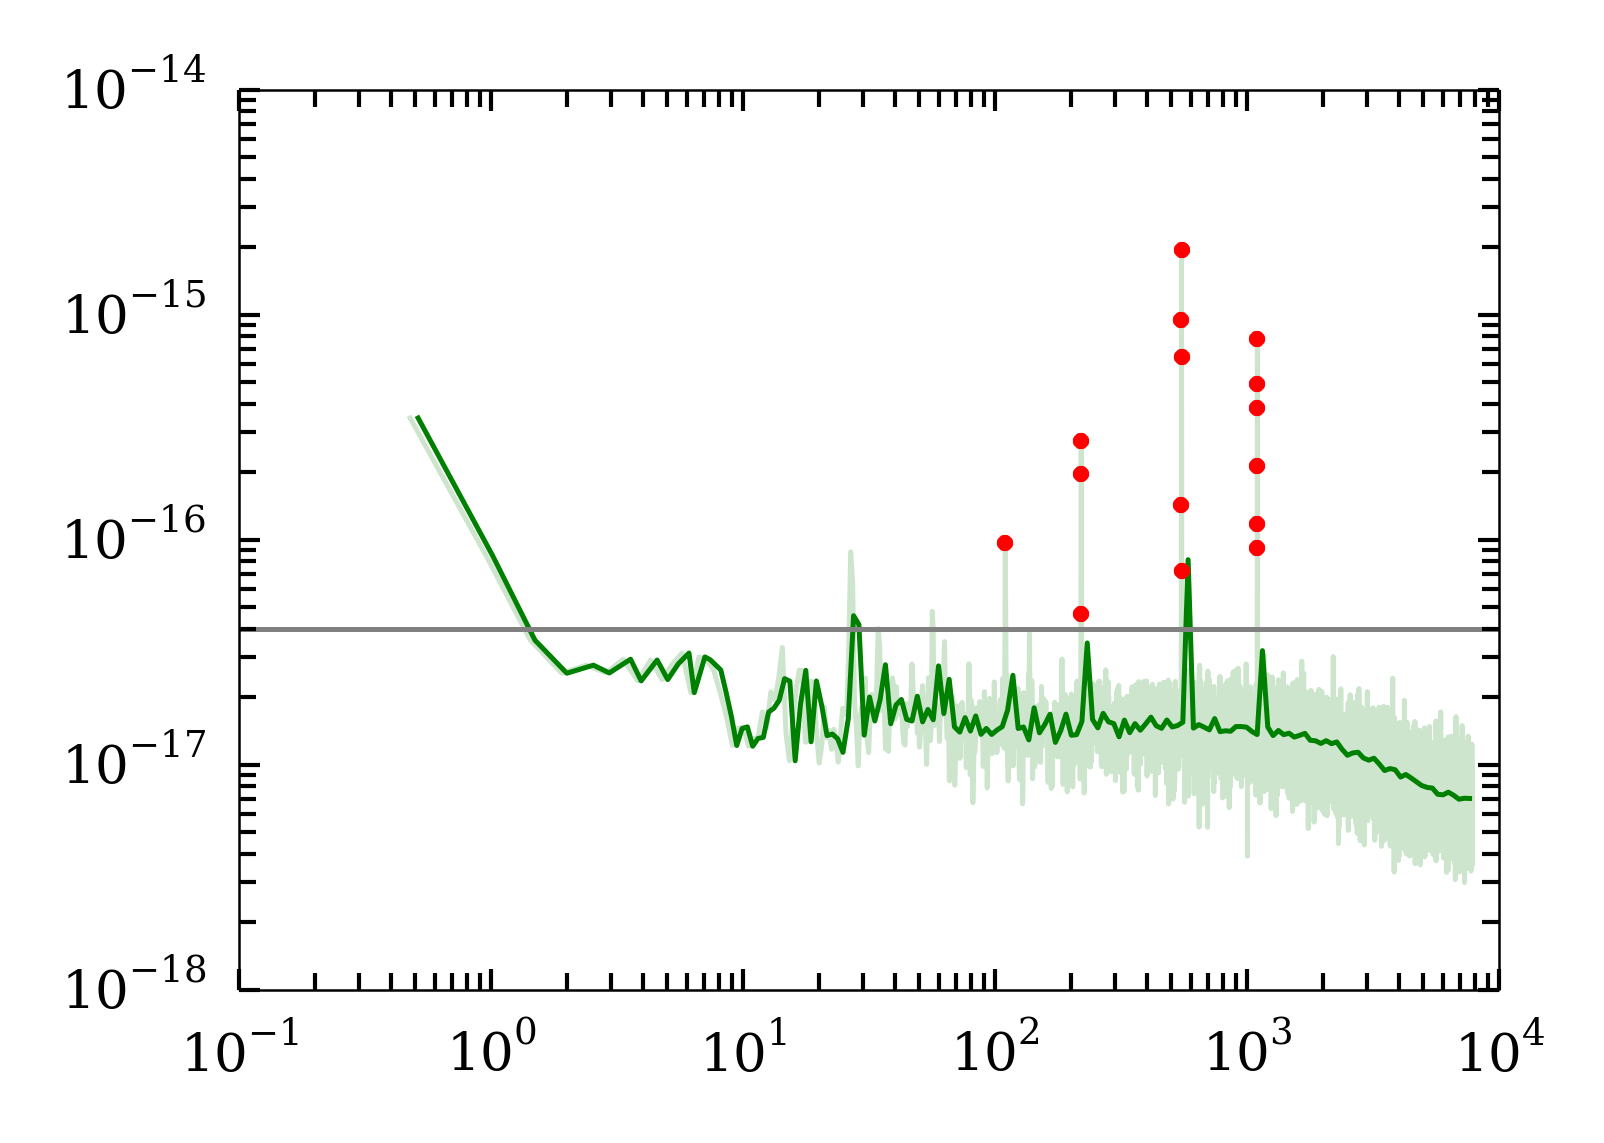

In [30]:
fig, ax = plt.subplots()

ax.loglog(bb_snm_a29_tt06.pca_freq[1:], bb_snm_a29_tt06.pca_eigvals[1][1:], '-g', alpha=0.2)
ax.loglog(bc06[counts06.astype(np.bool)], Sx06[counts06.astype(np.bool)], color='green', alpha=1)
ax.loglog(bb_snm_a29_tt06.pca_freq[highest], bb_snm_a29_tt06.pca_eigvals[1][highest], '.r')
ax.axhline(4e-17, color='gray')
#ax.set_ylim(3e-18, 3e-17)
#ax.loglog(cw_snm_a29_tt6.pca_freq, cw_snm_a29_tt6.pca_eigvals[0], '-')

In [31]:
bb_snm_a29_tt06.pca_freq[sorted(highest)]

array([  109.67254639,   218.86825562,   219.34509277,   219.82192993,
         547.88589478,   548.36273193,   548.83956909,   549.31640625,
         549.79324341,  1096.24862671,  1096.72546387,  1097.20230103,
        1097.67913818,  1098.15597534,  1098.6328125 ])

In [32]:
np.diff(sorted(highest))

array([ 229,    1,    1,  688,    1,    1,    1,    1, 1146,    1,    1,
          1,    1,    1])

In [33]:
with open(os.path.join(save_directory, 'bb_spikes.npy')) as f:
    np.save(f, sorted(highest))

In [34]:
bb_snm_a29_tt06._close_files()
del(bb_snm_a29_tt06)

# Create all SNMs and save data

In [35]:
# Exclude 2 * 9 turns and 2 * 8.5 turns
for bb_nc in bb_ncs[2:]:
    snm = noise_measurement.SweepNoiseMeasurement(bb_nc,
                                                  sweep_group_index=index_a29,
                                                  timestream_group_index=index_a29,
                                                  resonator_index=resonator_index,
                                                  pca_NFFT=pca_NFFT,
                                                  pca_detrend=mlab.detrend_none,
                                                  pca_use_log_bins=False)
    print("Turns {}".format(snm.mmw_atten_turns))
    with open(os.path.join(save_directory, 'bb_tt{:02.0f}.npy'.format(2 * snm.mmw_atten_turns[0])), 'w') as filename:
        np.save(filename, snm.pca_eigvals[1])
    with open(os.path.join(save_directory, 'bb_tt{:02.0f}_amp.npy'.format(2 * snm.mmw_atten_turns[0])), 'w') as filename:
        np.save(filename, snm.pca_eigvals[0])
np.save(os.path.join(save_directory, 'bb_f.npy'), snm.pca_freq)

Turns [ 8.  8.]
Turns [ 7.5  7.5]
Turns [ 7.  7.]
Turns [ 6.5  6.5]
Turns [ 6.  6.]
Turns [ 5.5  5.5]
Turns [ 5.  5.]
Turns [ 4.5  4.5]
Turns [ 4.  4.]
Turns [ 3.5  3.5]
Turns [ 3.  3.]


In [36]:
# Exclude 2 * 9 turns and 2 * 3 turns
for cw_nc in cw_ncs[1:-1]:
    snm = noise_measurement.SweepNoiseMeasurement(cw_nc,
                                                  sweep_group_index=index_a29,
                                                  timestream_group_index=index_a29,
                                                  resonator_index=resonator_index,
                                                  pca_NFFT=pca_NFFT,
                                                  pca_detrend=mlab.detrend_none,
                                                  pca_use_log_bins=False)
    print("Turns {}".format(snm.mmw_atten_turns))
    with open(os.path.join(save_directory, 'cw_tt{:02.0f}.npy'.format(2 * snm.mmw_atten_turns[0])), 'w') as filename:
        np.save(filename, snm.pca_eigvals[1])
    with open(os.path.join(save_directory, 'cw_tt{:02.0f}_amp.npy'.format(2 * snm.mmw_atten_turns[0])), 'w') as filename:
        np.save(filename, snm.pca_eigvals[0])
np.save(os.path.join(save_directory, 'cw_f.npy'), snm.pca_freq)

Turns [ 8.5  8.5]
Turns [ 8.  8.]
Turns [ 7.5  7.5]
Turns [ 7.  7.]
Turns [ 6.5  6.5]
Turns [ 6.  6.]
Turns [ 5.5  5.5]
Turns [ 5.  5.]
Turns [ 4.5  4.5]
Turns [ 4.  4.]
Turns [ 3.5  3.5]
